##ECE M214A Project: Speaker Region Identification



In this project, we'll train a machine learning algorithm to classify speakers by regional dialect.  We will use speech samples from the Corpus of Regional African American Language (CORAAL - https://oraal.uoregon.edu/coraal) with speakers each belonging to one of five different US cities: 1) Rochester, NY (ROC), 2) Lower East Side, Manhattan, NY (LES), 3) Washington DC (DCB), 4) Princeville, NC (PRV), or 5) Valdosta, GA (VLD).

The project files can be downloaded from [this link](https://ucla.box.com/s/d6durcy98r1ti6n97vu0u13pdg2i7xmh)

To do this, we will first extract features from the audio files and then train a classifier to predict the city of origin of the utterance's speaker.  The goal is to extract a feature that contains useful information about regional dialect characteristics.

## 2. Getting familiar with the data


Let's take a moment to understand the data.  The original CORAAL dataset consists of ~85 different speakers, each from one of five cities.  The audio files are names with the convention: DCB_se1_ag1_f_03.  Here, DCB is the city code, se1 denotes the socioeconomic group of the speaker, ag1 denotes the age group of the speaker, f denotes female, and 03 denotes the participant number.  These unique combinations of identifiers mark the speaker.  

The dataset has been preprocessed to only include audio segments greater than 10 seconds in length. there are a number of audio snippets of at least 10sec in length.  Those segments are numbered with the appending tag _seg_number for each segment.

You can also try listening to any segment like this:

In [369]:
from IPython.display import Audio

sr = 44100

Audio(filename= "/Users/zilaiwang/Documents/214-proj/W24_ECE_M214A_Project/project_data/train_clean/DCB_se1_ag1_f_03_1_seg_3.wav", rate=sr)

The original dataset has also been split into a train and test set. The test set has been further split, with a portion corrupted with the addition of noise:

In [370]:
sr = 44100

Audio(filename= "/Users/zilaiwang/Documents/214-proj/W24_ECE_M214A_Project/project_data/test_noisy/LES_se0_ag3_f_01_1_seg_57.wav", rate=sr)

In [371]:
import librosa
import scipy
import numpy as np

## 3. Feature Extraction

As a baseline, we will be using the average mfcc value over time from the Librosa Python library. Your job will be to choose better features to improve performance on both the clean and noisy data

We first define a pair of functions to create features and labels for our classification model:


In [372]:

# too slow for training
import librosa
import torchaudio
import numpy as np
from glob import glob
from tqdm import tqdm
from IPython.display import Audio

import numpy as np
import torchaudio

import numpy as np
import scipy.signal
import librosa

def stabilize_poles(lpc_coeffs):
    """Ensure all poles are within the unit circle for stability."""
    roots = np.roots(lpc_coeffs)
    stabilized_roots = np.array([root if np.abs(root) < 1 else root / np.abs(root) for root in roots])
    stabilized_coeffs = np.poly(stabilized_roots)
    return np.real_if_close(stabilized_coeffs, tol=1e-6)


def compute_lpc_coefficients(signal, fs, order):
    # Windowing the signal
    windowed_signal = scipy.signal.windows.hamming(len(signal)) * signal
    # Computing LPC coefficients
    lpc_coeffs = librosa.lpc(y = windowed_signal, order = order)
    #print('lpc coeffs:',lpc_coeffs)
    return lpc_coeffs
def compute_residual(signal, lpc_coeffs):
    # Applying the LPC filter to compute the residual
    filter_a = np.hstack([[1], -lpc_coeffs[1:]])
    residual = scipy.signal.lfilter(filter_a, [1], signal)
    #print('residual is: ',residual)
    return residual

def perturb_lpc_spectrum(lpc_coeffs, warping_range=(0.7, 1.2)): # warping factor cannot exceed 1
    """Perturb LPC spectrum by warping the phase of its poles."""
    roots = np.roots(lpc_coeffs)
    magnitudes = np.abs(roots)
    angles = np.angle(roots)

    # Apply random warping to the angles
    warping_factors = np.random.uniform(*warping_range, size=angles.shape)
    warped_angles = angles * warping_factors

    # Reconstruct the roots with warped angles
    warped_roots = magnitudes * np.exp(1j * warped_angles)

    # Convert the warped roots back to LPC coefficients
    warped_polynomial = np.poly(warped_roots)
    # Ensure poles are stabilized
    warped_lpc_coeffs = stabilize_poles(-warped_polynomial[1:])
    #warped_lpc_coeffs = -warped_polynomial[1:]
    
    return warped_lpc_coeffs
    

# def reconstruct_signal(residual, warped_lpc_coeffs):
#     filter_a_warped = np.hstack([[1], warped_lpc_coeffs])
#     #print('filter_a_warped: ',filter_a_warped)
#     reconstructed_signal = scipy.signal.lfilter([1], filter_a_warped, residual) # the output is too large
#     print('reconstructed_signal: ',reconstructed_signal)
#     return reconstructed_signal

def reconstruct_signal(residual, lpc_coeffs):
    """Reconstruct the signal from its residual and LPC coefficients."""
    # Ensure the LPC filter is stable before applying
    stable_lpc_coeffs = stabilize_poles(lpc_coeffs)
    
    # Apply the LPC filter to reconstruct the signal
    filter_a = np.hstack([[1], -stable_lpc_coeffs])
    reconstructed_signal = scipy.signal.lfilter([1], filter_a, residual)
    #print(reconstructed_signal)
    
    # Clip the reconstructed signal to prevent overflow or underflow issues
    reconstructed_signal = np.clip(reconstructed_signal, -1.0, 1.0)
   # print(reconstructed_signal)
    reconstructed_signal = np.abs(reconstructed_signal)
    return reconstructed_signal


def extract_feature(audio_file, order=10, frame_size_ms=25, step_size_ms=10, resample=False, fs_target=16000,augment = True):
    signal, fs = torchaudio.load(audio_file)
    signal = signal.numpy().reshape(-1)
    
    mfccs = librosa.feature.mfcc(y=signal, sr=fs, n_mfcc=13)
    feat_out = np.mean(mfccs,axis=1)
    if(augment == True):
        # Frame blocking parameters
        frame_length = int(fs * frame_size_ms / 1000)
        step_size = int(fs * step_size_ms / 1000)

        augmented_signal = np.array([])

        for start in range(0, len(signal) - frame_length + 1, step_size):
            end = start + frame_length
            frame = signal[start:end]

            # LPC Analysis
            lpc_coeffs = compute_lpc_coefficients(frame, fs, order)

            # Compute Residual
            residual = compute_residual(frame, lpc_coeffs)

            # Perturb LPC Spectrum
            warped_lpc_coeffs = perturb_lpc_spectrum(lpc_coeffs)

            # Reconstruct Signal Frame
            reconstructed_frame = reconstruct_signal(residual, warped_lpc_coeffs)
            #print(reconstructed_frame)

            # Concatenate to the augmented signal
            augmented_signal = np.concatenate((augmented_signal, reconstructed_frame))
            #print('agumented signal: ',augmented_signal)
            mfccs_aug = librosa.feature.mfcc(y=augmented_signal, sr=fs, n_mfcc=13)
            feat_out_aug = np.mean(mfccs_aug,axis=1)
            
            #print(augmented_signal)
            return feat_out,feat_out_aug
            #return feat_out_aug
    


    return feat_out









In [373]:

def get_label(file_name):
  '''
  Function to retrieve output labels from filenames
  '''
  if 'ROC' in file_name:
    label=0
    # global ROC
    # ROC = ROC+1
  elif 'LES' in file_name:
    label=1
    # global LES
    # LES = LES+1
  elif 'DC' in file_name:
    label=2
    # global DC
    # DC = DC+1
  elif 'PRV' in file_name:
    label=3
    # global PRV
    # PRV = PRV+1
  elif 'VLD' in file_name:
    label=4
    # global VLD
    # VLD = VLD+1
  else:
    raise ValueError('invalid file name')
  return label

Let us now call these functions to extract the features and labels from the train_clean directory

In [374]:

# #First we obtain the list of all files in the train_clean directory
# train_files = glob('/Users/zilaiwang/Documents/214-proj/W24_ECE_M214A_Project/project_data/train_clean/*.wav')

# #Let's sort it so that we're all using the same file list order
# #and you can continue processing the features from a given file if it stops
# #partway through running
# train_files.sort()

# train_feat=[]
# train_label=[]

# for wav in tqdm(train_files):
#   label = get_label(wav)
#   #feature = extract_feature(wav)
#   if(label==1):
#     feature=extract_feature(wav)
#     train_feat.append(feature)
#     #print(feature.shape)
#     #print(feature)
#     train_label.append(label)
    

In [375]:

#First we obtain the list of all files in the train_clean directory
train_files = glob('/Users/zilaiwang/Documents/214-proj/W24_ECE_M214A_Project/project_data/train_clean/*.wav')


train_files.sort()

train_feat=[]
train_label=[]

# for wav in tqdm(train_files):
#   temp = extract_feature(wav)
#   #print(temp) 
#   train_feat.append(temp)
#   train_label.append(get_label(wav))

n_augmentations = 1  # Number of additional augmentations to append
for wav in tqdm(train_files):
  label = get_label(wav)
  original_feat, augmented_feat = extract_feature(wav)
  #original_feat = extract_feature(wav)
  
  #print(temp) 
  # print(original_feat)
  # print(augmented_feat)

  train_feat.append(original_feat)
  train_label.append(label)
  if augmented_feat is not None and (label!=2 ):# 1 for LES
      train_label.append(label) 
      train_feat.append(augmented_feat)

       # Append additional augmentations if required
      # for _ in range(n_augmentations):
      #       __, additional_augmented_feat = extract_feature(wav, augment=True)
      #       train_feat.append(additional_augmented_feat)
      #       train_label.append(label)
  # elif augmented_feat is not None and (label==4):
  #     train_label.append(label) 
  #     train_feat.append(augmented_feat)

print("Len of train feat: ",len(train_feat))
print("len of train label: ",len(train_label))
# print(ROC,
# LES,
# PRV,
# DC,
# VLD)


  0%|          | 3/4372 [00:00<06:02, 12.04it/s]

100%|██████████| 4372/4372 [05:08<00:00, 14.18it/s]

Len of train feat:  6287
len of train label:  6287


In [376]:
#Now we obtain the list of all files in the test_clean directory
test_clean_files = glob('/Users/zilaiwang/Documents/214-proj/W24_ECE_M214A_Project/project_data/test_clean/*.wav')

#Similar to above, we sort the files
test_clean_files.sort()

test_clean_feat=[]
test_clean_label=[]

for wav in tqdm(test_clean_files):

  test_clean_feat.append(extract_feature(wav,augment = False))
  #print(np.asarray(test_clean_feat).shape)
  test_clean_label.append(get_label(wav))
print(np.asarray(test_clean_feat).shape)

  0%|          | 0/447 [00:00<?, ?it/s]

100%|██████████| 447/447 [00:28<00:00, 15.54it/s]

(447, 13)


In [377]:
#Finally we obtain the list of all files in the test_noisy directory
test_noisy_files = glob('/Users/zilaiwang/Documents/214-proj/W24_ECE_M214A_Project/project_data/test_noisy/*.wav')

#Similar to above, we sort the files
test_noisy_files.sort()

test_noisy_feat=[]
test_noisy_label=[]

for wav in tqdm(test_noisy_files):

  test_noisy_feat.append(extract_feature(wav,augment = False))
  test_noisy_label.append(get_label(wav))

  0%|          | 0/347 [00:00<?, ?it/s]

100%|██████████| 347/347 [00:25<00:00, 13.41it/s]


## 4. Model Training and Predictions

Now we'll train the backend system to predict the regions from the input features.  We'll use an xgboosted decision tree for this.  An advantage of this model is that we can also parse the decision tree and measure the impact of different features in the end result for explainability

In [378]:
#Install shap library
#!pip install shap

In [379]:
import xgboost
import numpy as np
import shap
import pandas as pd

#Format input data

#Edit this variable to create a list that contains your feature names
feat_names=['mfcc_' +str(n) for n in range(len(train_feat[0]))]

train_feat_df = pd.DataFrame(data=np.stack(train_feat), columns=feat_names)
y_train=np.stack(train_label)


test_clean_feat_df = pd.DataFrame(data=np.stack(test_clean_feat), columns=feat_names)
y_test_clean=np.stack(test_clean_label)


test_noisy_feat_df = pd.DataFrame(data=np.stack(test_noisy_feat), columns=feat_names)
y_test_noisy=np.stack(test_noisy_label)


#you could just pass in the matrix of features to xgboost
#but it looks prettier in the shap explainer if you format it
#as a dataframe.


model = xgboost.XGBClassifier()
model.fit(train_feat_df,y_train)

print("Train Clean Acc =", np.sum(y_train==model.predict(train_feat_df))/len(y_train))

print("Test Clean Acc =", np.sum(y_test_clean==model.predict(test_clean_feat_df))/len(y_test_clean))

print("Test Noisy Acc =", np.sum(y_test_noisy==model.predict(test_noisy_feat_df))/len(y_test_noisy))


Train Clean Acc = 0.9998409416255766
Test Clean Acc = 0.7695749440715883
Test Noisy Acc = 0.6080691642651297


To save a dataframe of features, uncomment and run the following block of code

In [380]:
# train_feat_df.to_csv('drive/MyDrive/current_features.csv')

To Load a preexisting dataframe of features (saved from a previous notebook), run the following cell and then train the model

In [381]:
# train_feat_df = pd.read_csv('drive/MyDrive/myfeat_train.csv')
# test_clean_feat_df = pd.read_csv('drive/MyDrive/myfeat_test_clean.csv')
# test_noisy_feat_df = pd.read_csv('drive/MyDrive/myfeat_test_noisy.csv')

## 5. Interpreting Results and Explainability

To see the impact different features have on the model, we create a plot of the feature importances. The features are listed top to bottom in order of how important they were to the decision.

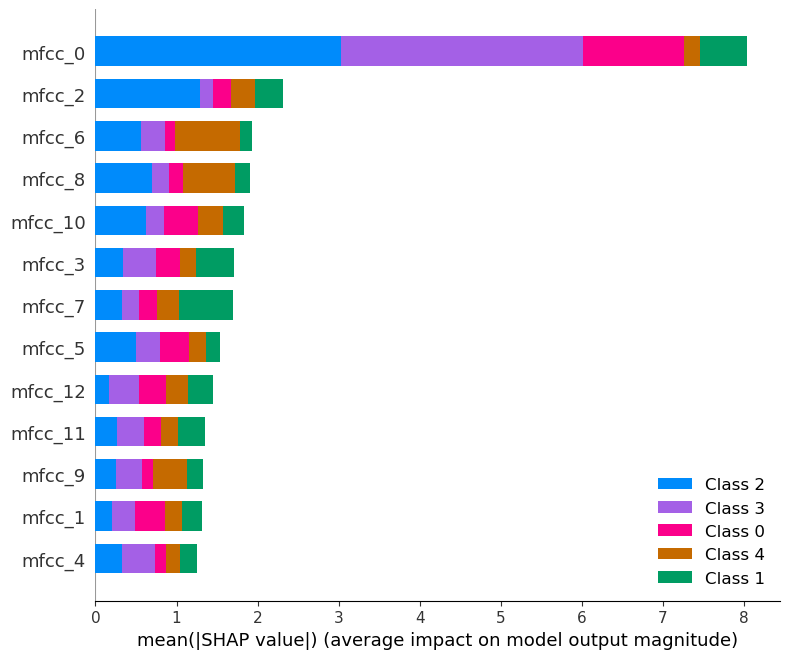

In [382]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_feat_df)
shap.summary_plot(shap_values, train_feat_df)

And we can see a confusion matrix of the mispredictions

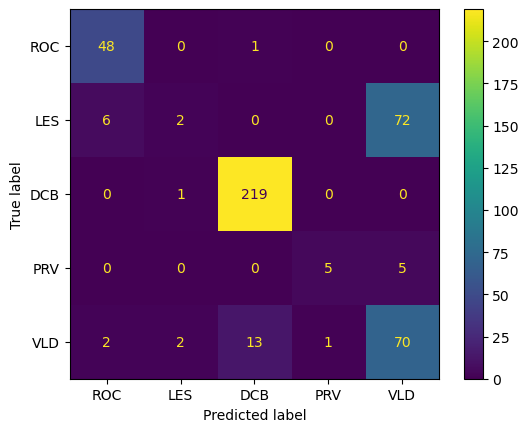

In [383]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix_clean = metrics.confusion_matrix(y_test_clean, model.predict(test_clean_feat_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_clean, display_labels = ['ROC','LES','DCB','PRV','VLD'])
cm_display.plot()
plt.show()

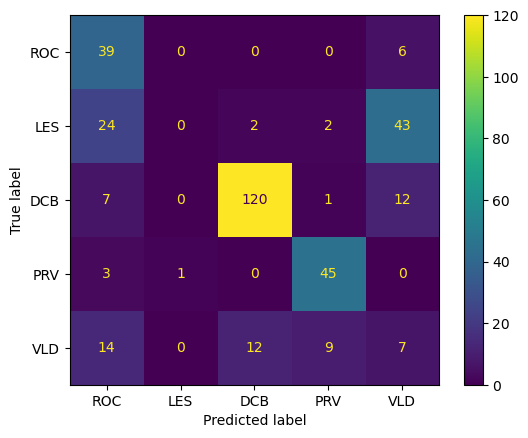

In [384]:

confusion_matrix_noisy = metrics.confusion_matrix(y_test_noisy, model.predict(test_noisy_feat_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_noisy, display_labels = ['ROC','LES','DCB','PRV','VLD'])
cm_display.plot()
plt.show()